# Introduction

The goal of the previous analysis was finding the models (function approximations) that map some unseen data to most likely outcome. Supervised algorithms which were applied to the task provided predictive power measurable by ratio of correct answers. However, even the most accurate models revealed little about the structure of the data. Unsupervised algorithms help fill out this gap by providing means of finding subpopulations within the data by estimating distributions of data over different clusters.

In [634]:
%matplotlib inline
from algo_evaluation.handle_imports import *

# Classification Data Review

__Higgs Data quick review__:

   - given outcomes of particle decays, detect Higgs boson particle (signal); 
   
   - most of the __supervised__ algorithms gave acceptable accuracy ranging from __0.8 - 0.9__ and far outperforming the __backpropagation__ algorithm for neural networks (__0.5__ which is as good as flip of the coin but a lot more computationally expensive)
   
   - __learning weights__ with Randomized Optimization algorithms improved accuracy of the neural network to __0.7__ and higher (Genetic Algorithm)
   
__Additional Data Wrangling__:

   - features were __rescaled__ as a requirement to feature transformation algorithms
   
   - previously manually pruned features were put back to allow feature selection algorithms to automatically choose the most informative ones
   
   - dataset was not reduced in size since dimensionality reduction provides speed advantage (the main reason for sampling records in the previous analysis)

In [4]:
higgs_data = datasets.load_higgs_train(sample_size=None, verbose=True, scale=True, 
                                       prune_features=False)
all_higgs_features = higgs_data[0].shape[1]

Size of the dataset: 68114
Number of features: 30
Number of positives (signal): 31894
Number of negatives (background): 36220


__Converters Data quick review__:

   - given online users' behavior and preferences predict whether or not ad display will result in conversion; 
   
   - in contrast to Higgs dataset, supervised algorithm on this datataset provided high accuracy >94%
   
   - converters dataset as a result was not subjected to randomized optimization analysis

In [392]:
bid_data = datasets.load_bidding_train(verbose=True, scale=True)
all_bid_data_features = bid_data[0].shape[1]

Size of the dataset: 57970
Number of features: 15
Number of converters: 399
Number of non-converters: 54615
Number of leads: 2956


# K-means Clustering

K-means is the simplest algorithm which separates data into groups with equal variance minimizing within-clusters sum-of-squares. For evaluating clustering performance it is typical to use similarity metric: did clustering define separations of data similar to ground truth ( an example is __Adjusted Rand Index__ that measures the similarity of the two assignments, ignoring permutations and with chance normalization).

__Model Selection (cluster complexity)__

Best data separation for __Higgs__ data is achieved with number of clusters equal __2__ which makes sense since there are two classes in the data: signal and background, so the clustering lined up with labels. As number of the clusters grow, similarity measure gradually approaches zero and uniformity of the data withing each group decreases.

__Converters__ dataset achieves best separation for a single class which is the same as saying that clustering algorithm could not split data into groups. Since a single cluster does not make sense, it is reasonable to analyze next best separation. There is no clear convergence in this case towards a certain number of clusters and moreover, cluster assignment does not line up with labels, so it is OK to choose an arbitrary number (we can stick with __10__ and see how well that compares with dimensionality reduction algorithms).

In [350]:
df_kmeans_higgs = kmeans_eval.estimate_clusters(higgs_data)

In [367]:
df_kmeans_converters = kmeans_eval.estimate_clusters(bid_data)

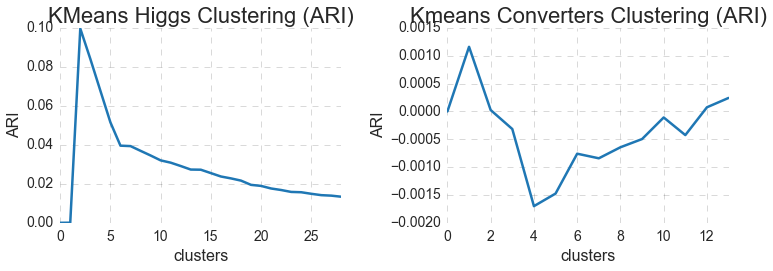

In [368]:
plot_cluster_estimation.plot_kmeans_cluster_score(df_kmeans_higgs, df_kmeans_converters)

__Insight__: Neither of the above data separation is considered good (ARI=1.0 is a perfect score). Since scores are close to 0.0, label assignment is rather uniform especially for converters data. This suggests that datasets have more complex structure and are not easily separable into groups.

# Expectation Maximization

As a second approach to clustering we will use the probabilistic model with assumption that all data points are generated from the number of Gaussian distributions. As a measure metric, we can use the scoring method which computes the __log probability__ under the model. 

In [355]:
df_gmm_higgs = gmm_eval.estimate_clusters(higgs_data)

In [369]:
df_gmm_converters = gmm_eval.estimate_clusters(bid_data)

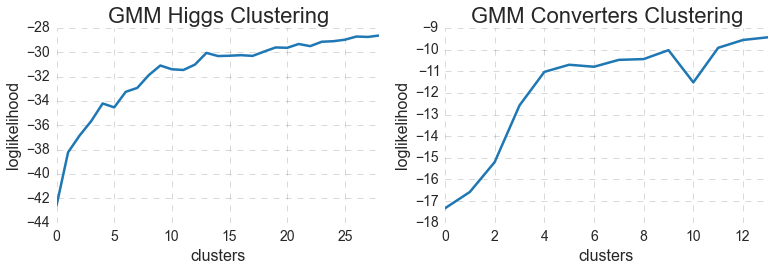

In [370]:
plot_cluster_estimation.plot_gmm_cluster_score(df_gmm_higgs, df_gmm_converters)

For __Higgs__ dataset, loglikelihood of data is increasing as number of latent variables (here number of Gaussian distributions) is increasing which suggests that every single feature came from a Gaussian distribution with unique parameters (means and variances).

For __Converters__ dataset, loglikelihood is increasing as well, however it is important to note that in the range of clusters from 4 to 9 probability increase is not very significant, so it is OK to make an assumption that data generally comes from 4 distinct distributions. 

# Feature Selection and Transformation for Higgs Dataset

In the previous analysis, Higgs records were sampled and features were manually pruned due to the slow speed of supervised algorithms. In this analysis, complete dataset is restored to take advantage of automatic feature selection using dimensionality reduction algorithms.

Dimensionality reduction is the task of deriving a set of features that is smaller than the original feature set while retaining most of the variance of the original data. 

## Principal Component Analysis (PCA)

To estimate the best number of components to be used for data transformation, I used __data variance__ analysis to choose optimal setting.
PCA estimates percentage of variance explained by each of the components. I extracted those variances (eigenvalues) for each feature and sorted them from largest to smallest. 

Visualizing the results made it clear that "Derived" features from Higgs dataset have larger spread than "Primitives" and thus are more informative for classification. This supports the decision made in the previous analysis where "Primitive" features were pruned based on feature by feature analysis.

In [51]:
pca_rank = pca_eval.rank_features(higgs_data, n_components=all_higgs_features)

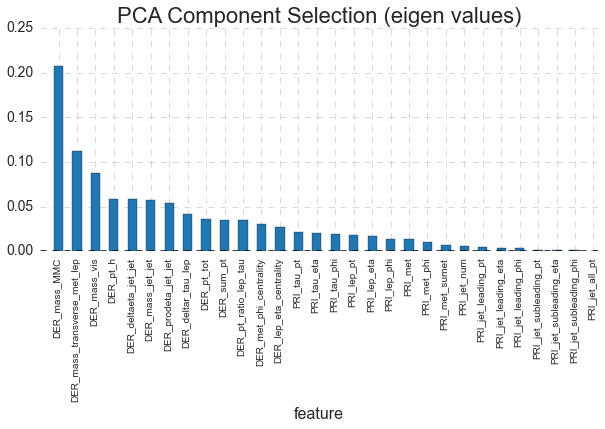

In [52]:
pca_eval.plot_rank(pca_rank, title='PCA Component Selection (eigen values)')

__Reducing features while retaining data variance__:

When applying dimensionality reduction, it is important to retain certain threshold of data variance. In addition to visual inspeaction, I selected features which retained __95%__ of data variance (dimensionality reduced from 30 to 7).
Algorithm ranked features _DER_mass_MMC_ the highest which makes sense since this feature estimates mass of the Higgs boson candidate and indeed is the most informative.

In [168]:
reduced_features = pca_rank.variance_ratio[pca_rank.variance_ratio > 0.05]
reduced_features

feature
DER_mass_MMC                   0.207485
DER_mass_transverse_met_lep    0.112727
DER_mass_vis                   0.087133
DER_pt_h                       0.058547
DER_deltaeta_jet_jet           0.058122
DER_mass_jet_jet               0.057542
DER_prodeta_jet_jet            0.053497
Name: variance_ratio, dtype: float64

## Independent Component Analysis (ICA)

By minimizing the Gaussianity of the projection, ICA is designed to recover the underlying physical process which generated the observed data. 

__Model Selection__:
Selecting number of components for ICA dimensionality reduction can be achieved by using a criteria which determines how close to Gaussian is the feature distribution (kurtosis)

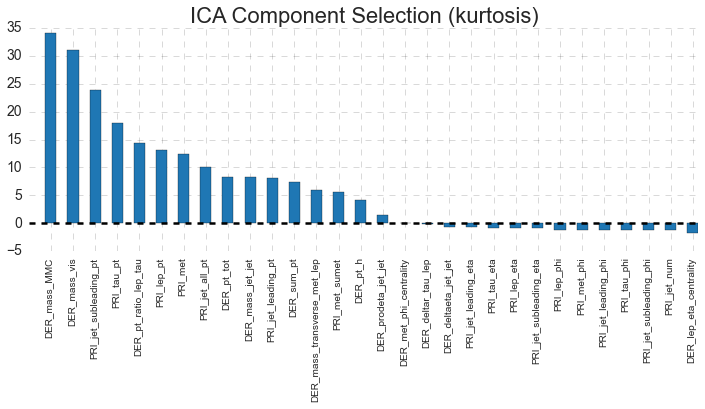

In [35]:
ica_comp = ica_eval.estimate_components(higgs_data, display=True)

__Insight__: Half of the features have kurtosis value close to 0 which means that their distribution is very close to Gaussian and thus those features are less likely to be the sources of underlying physical process. Note that _DER_mass_MMC_ is again the top feature so it is becoming more likely that this feature is the best component to be selected among other 14 (based on the selection criteria: kurtosis > 5.0)

__Mixing Matrix__

To get an intuition on how ICA is reconstructing the signal, I visualized the estimated mixing matrix as a heat map to see how much the actual outcomes of physical processes for colliding particles are mixed in the observable features. Note, that overall, the data is not too muddy which means a lot of features are independent (prevalence of light areas over the darker ones)

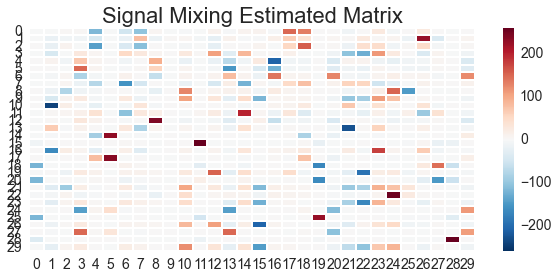

In [49]:
mm = ica_eval.mixing_matrix(higgs_data, all_higgs_features, display=True)

## Randomized Component Analysis (RCA)

When processing time and model simplicity is more important than accuracy, then data dimension can be reduced using randomized projections which is computationally the most efficient and it producing good results! 

__Model Selection__:

To estimate number of minimum dimensions we can use Johnson-Lindenstrauss lemma, which states there exist a mapping from high-dimensional to low-dimensional Euclidian space, such that distance between the points is preserved within some epsilon variance (to be consistent with the previous experiment, epsilon will be set to 5%)

In [7]:
johnson_lindenstrauss_min_dim(n_samples=len(higgs_data[0]), eps=0.05)

36840

We obviously cannot achieve required dimension as Higgs data only has 30 features, however this is only a theoretical assumption and since in the end we care about classifier accuracy (Higgs detection), we can estimate number of components by using following experiment setup:

- use accuracy of linearSVC classifier on full feature dimension as a baseline (in the plot below indicated by iteration 0)
- iterate over number of components and re-evaluate accuracy of the classifier on the transformed data
- since projections are  _randomized_, we repeat the experiment multiple times to understand how much the result varies (iterations 1-9) 


In [640]:
rca_trans = rand_projections.estimate_components(higgs_data)

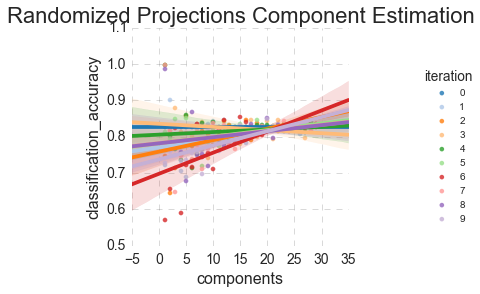

In [642]:
rand_projections.plot_component_estimation(rca_trans)

__Insight 1__: For small values of components, variability of projections from iteration to iteration is quite large and the accuracy scores are spread out from 0.5 to almost perfect 1.0. By fitting the points through the first degrees polynomial it becomes clear that accuracy is increasing as number of projected components is growing.

__Insight 2__: The sweet spot for number of components is around 10 where 1) variability of the projections decreases and 2) accuracy of the classifier with reduced components started to outperform the baseline. 

# Feature Selection and Transformation for Converters Dataset

Same principles and technique were applied to select features for converters dataset (retaining data variance of 95%)

In [251]:
pca_rank_bid = pca_eval.rank_features(bid_data, n_components=all_bid_data_features)

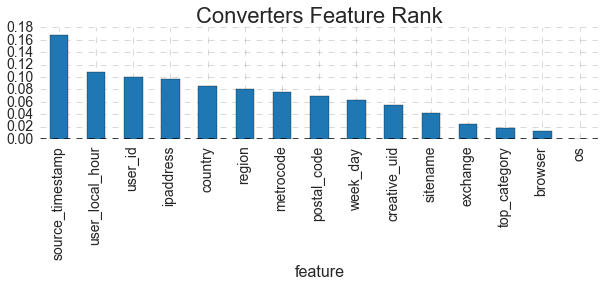

In [644]:
pca_eval.plot_rank(pca_rank_bid, title='Converters Feature Rank', figsize=(10,2))

In [643]:
red_conv_feat = pca_rank_bid.variance_ratio[pca_rank_bid.variance_ratio > 0.05]
reduced_conv_dimension = len(red_conv_feat)
print 'Estimated number of reduced components =', reduced_conv_dimension

Estimated number of reduced components = 10


__Insight__: Some of features (like sitename) were pruned by not contributing to data spread (small eigen value); this suggests that the local user time is more important differentiator as to whether or not ad will result in conversion.

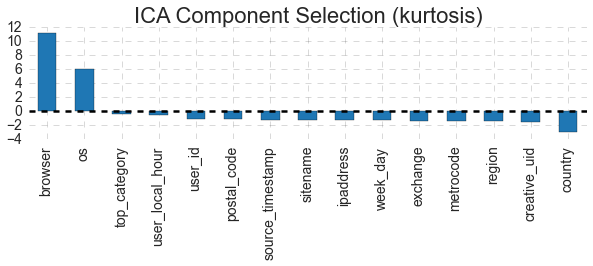

In [647]:
bid_ica_comp = ica_eval.estimate_components(bid_data, display=True, figsize=(10, 2))

Analyzing the Gaussanity of the Converters dataset (to get an insight of the what ICA is going to try to accomplish here) suggests the following:

- only two features (browser and OS) are very distinct from the normal distribution and thus are the best independent components. 
- the rest of the feature appear to be a mix of observations from which it would be hard to extract independence. 

__Insight__: Since the nature of the converters data is collecting user logs, it does not make much sense to extract components which generate the observation. This could also be effect of having categorical data which in the process of re-encoding lost a portion of the structure.

# Neural Networks on Higgs dataset post Dimensionality Reduction

In the next experiment, prior to classification, Higgs dataset is reduced using four algorithms: PCA, ICA, RCA and LSA. Same error measure is applied as in the previous analysis where Higgs boson was classified with Neural Networks.

In [408]:
df_nn = nn.evaluate_nn_accuracy(higgs_data, reduced_higgs_dimension)

In addition to comparing the classification error between different dimensionality reduction algorithms, I added results from previous two algorithms (Backpropagation and Weights Learning with Genetic Algorithm) to be used as a baseline. 

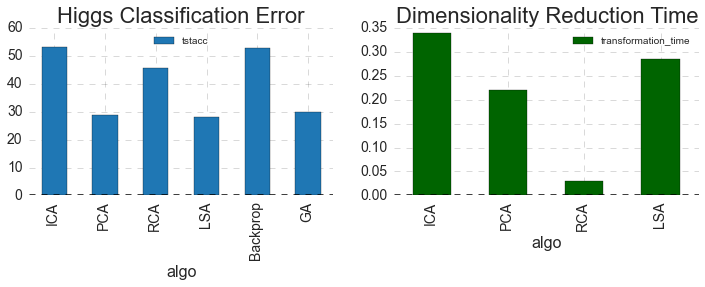

In [468]:
nn.plot_evaluation(df_nn)

Very notable is the fact that __PCA__ dimension reduction has improved classification error as compared to Backpropagation and is on par with Genetic Algorithm which performed best for learning weights. Reducing dimensions with randomized projection (__RCA__) does have not the best accuracy, however the speed of the algorithm is amazingly fast compared to all others and so it can be very beneficial in the cases accuracy could be sacrificed to avoid the curse of dimensionality.

While __LSA__ gave similar accuracy performance to __PCA__ (since it reduced the dataset to the same components), the transformation time of the algorithm did not demonstrate computation efficiency since Higgs dataset is not sparse in which case LSA could have in advantage. 

# Clustering post Dimensionality Reduction

Clustering experiments are repeated with projected data which in both dataset if smaller than the original dimensionality: Higgs (30 -> 7) and Converters (15 -> 10).
Neither Kmeans or GMM showed a different structure on the projected datasets (plot removed in favor of space limitation), so the same insights about data distribution are preserved.

__Runtime comparsion of the clustering time__

In [552]:
higgs_time_df = clustering_dim_reduction.compare_cluster_runtime(higgs_data, 2, 7)

In [553]:
conv_time_df = clustering_dim_reduction.compare_cluster_runtime(bid_data, 3, 10)

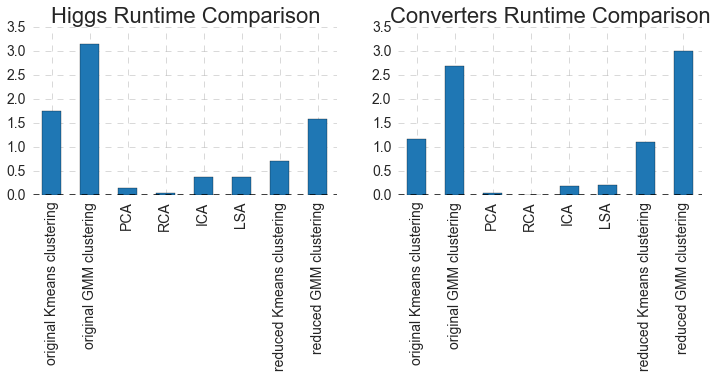

In [554]:
clustering_dim_reduction.plot_running_time(higgs_time_df, conv_time_df)

Another benefit of feature transformation algorithms (besides knowledge discovery) is the __speed__ gain after projecting the original data to reduced dimensions. 

__Higgs__ clustering experiment: Reduce the data dimension from 30 to 7 and compare Kmeans and GMM clustering runtime before and after (2 clusters - signal and background). Both gained in speed improvement without loss of the data structure (even the slowest feature transformation algorithm proved to be beneficial to overall time saving)

__Convertes__ clustering experiment: Reduce the data dimension from 15 to 10 and compare Kmeans and GMM clustering runtime before and after (3 clusters - converters, lead and non-converters). In order to preserve the original data structure (retaining 95% of variance), converters dataset dimensionality was not reduced as much as Higgs dataset. Note that in this case, projecting data to new dimensions and re-estimating the distribution is actually slower and thus there is no real benefit in transforming data other than visualization.  

# Neural Networks on Higgs dataset post Clustering as Dimensionality Reduction

To recapitulate this final experiment, following reductions and transformation were done:

  - Project the original dataset of 30 features to new dataset of 7 features where 95% of data variance is retained.
  - Run Kmeans Clustering with 2 clusters as suggested by model complexity analysis and add cluster-distance spaces as new features.
  - Run GMM distribution estimation with 4 components as suggested by model analysis and add distribution estimation as a new feature to PCA projected set
  - Rerun neural network classification with 9D (7 features + 2 cluster-distance space features) and 8D (7 features + 1 distribution assignment) data dimension

In [581]:
higgs_data_9d, _ = clustering_dim_reduction.kmeans_transform(higgs_data, 2, 7)

In [582]:
higgs_data_8d, _ = clustering_dim_reduction.gmm_transform(higgs_data, 4, 7)

In [583]:
_, _, err_9d = clustering_dim_reduction.neural_net_post_clustering(higgs_data_9d)

In [584]:
_, _, err_8d = clustering_dim_reduction.neural_net_post_clustering(higgs_data_8d)

In [592]:
err = pd.Series([28.739212, err_9d, err_8d], index=['Error on PCA reduced data',
                                                    'Error with new features added by KNN',
                                                   'Error with new features added by GMM'])
err

Error on PCA reduced data               28.739212
Error with new features added by KNN    29.281965
Error with new features added by GMM    28.485630
dtype: float64

__Outcome__: There is no significant change in the accuracy of the classification with adding new features (cluster assignment and distribution estimation) to the existing dataset. It appears they are not adding new information and their usefulness is already encoded in the current set of features. The real benefit of the clustering and data transformation manifested itself in the significant speed gains (thus a great remedy to the curse of dimensionality) and in the understanding the feature space (thus increasing the domain knowledge).